<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/master/machine%20translation%20projects/Seq2Seq/Seq2SeqColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-gpu --quiet

     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 3.8MB 56.9MB/s 
     |████████████████████████████████| 450kB 66.2MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.1 which is incompatible.


In [2]:
!git clone https://github.com/mizzmir/data.git

Cloning into 'data'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [0]:
import os
import re
import sys
import unicodedata
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def normalize(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?-]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def read_data(data_dir, file_name):
    full_path = os.path.join(data_dir, file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      lines = file.readlines()
    
    data = []

    for line in lines:
        data.append(line.split("\t")[:-1])
    
    return data

def read_data_files(data_dir, file_names):
    
    en_file_name, fr_file_name = file_names
    
    full_path = os.path.join(data_dir, en_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      en_lines = file.readlines()
    
    full_path = os.path.join(data_dir, fr_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      fr_lines = file.readlines()    
    
    return en_lines, fr_lines

def preprocessSeq(texts, tokenizer):
  texts = tokenizer.texts_to_sequences(texts)

  return pad_sequences(texts, padding='post')

def tokenizeInput(input_data, tokenizer):
    output_data = []
    for data in input_data:
        tokenizer.fit_on_texts(data)
    
    for data in input_data:
        output_data.append(preprocessSeq(data, tokenizer))
    
    return output_data

In [5]:
data_dir = "/content/data"

# reading data
#en_lines, fr_lines = read_data_files(data_dir, ("small_vocab_en", "small_vocab_fr"))

data = read_data(data_dir, "fra.txt")
en_lines, fr_lines = list(zip(*data))

en_lines = en_lines[:40000]
fr_lines = fr_lines[:40000]


en_lines = [normalize(line) for line in en_lines]
fr_lines = [normalize(line) for line in fr_lines]

en_train, en_test, fr_train, fr_test = train_test_split(en_lines, fr_lines, shuffle=True, test_size=0.1)

fr_train_in = ['<start> ' + line for line in fr_train]
fr_train_out = [line + ' <end>' for line in fr_train]

fr_test_in = ['<start> ' + line for line in fr_test]
fr_test_out = [line + ' <end>' for line in fr_test]

fr_tokenizer = Tokenizer(filters='')
en_tokenizer = Tokenizer(filters='')

input_data = [fr_train_in, fr_train_out, fr_test_in, fr_test_out, fr_test, fr_train]
fr_train_in, fr_train_out, fr_test_in, fr_test_out, fr_test, fr_train = tokenizeInput(input_data,
                                                                                      fr_tokenizer)

input_data = [en_train, en_test]
en_train, en_test = tokenizeInput(input_data, en_tokenizer)

en_vocab_size = len(en_tokenizer.word_index)+1
fr_vocab_size = len(fr_tokenizer.word_index)+1
print("en_vocab {}\nfr_vocab {}" .format(en_vocab_size, fr_vocab_size))

reading data from  /content/data/fra.txt
en_vocab 5178
fr_vocab 9851


In [0]:
#
# Encoder Decoder
#
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, units):
    super(Encoder, self).__init__()

    self.units = units
    self.embeding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size, mask_zero=True, trainable=True)
    self.lstm_layer = tf.keras.layers.LSTM(units, dropout=0.2, return_sequences=True, return_state=True)
  
  def call(self, sequences, lstm_states):
    # sequences shape = [batch_size, seq_max_len]
    # lstm_states = [batch_size, lstm_size] x 2
    # encoder_embedded shape = [batch_size, seq_max_len, embedding_size]
    # output shape = [batch_size, seq_max_len, lstm_size]
    # state_h, state_c shape = [batch_size, lstm_size] x 2

    encoder_embedded = self.embeding_layer(sequences)
    #print("encoder_embedded = ", encoder_embedded.shape)
    output, state_h, state_c = self.lstm_layer(encoder_embedded, initial_state=lstm_states)

    return output, state_h, state_c

  def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.units]),
                tf.zeros([batch_size, self.units]))

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, units):
    super(Decoder, self).__init__()

    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm_layer = tf.keras.layers.LSTM(units, dropout=0.2, return_sequences=True,
                                           return_state=True)
    self.dense_layer = tf.keras.layers.Dense(vocab_size)
  
  def call(self, sequences, lstm_states):
    # sequences shape = [batch_size, seq_max_len]
    # embedding shape = [batch_size, seq_max_len, embedding_size]
    # output shape = [batch_szie, seq_max_len, lstm_size]
    # state_h, state_c = [batch_size, lstm_size] x2
    # dense shape = [batch_size, seq_max_len, vocab_size]
    
    decoder_embedded = self.embedding_layer(sequences)
    lstm_output, state_h, state_c = self.lstm_layer(decoder_embedded, lstm_states)
    return self.dense_layer(lstm_output), state_h, state_c

In [0]:
LSTM_SIZE = 512
EMBEDDING_SIZE = 250
BATCH_SIZE= 64
EPOCHS = 20

In [0]:
class Seq2SeqTrainer:
    def __init__(self, batch_size, lstm_size, embedding_size, predict_every):
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.embedding_size = embedding_size
        self.predict_every = predict_every
        self.strategy = tf.distribute.MirroredStrategy()
        self.encoder = None
        self.decoder = None
        self.optimizer = None
        self.fr_tokenizer = None
        self.en_tokenizer = None
    
    def predict(self, input_data, real_data_out):
      en_sentence = self.en_tokenizer.sequences_to_texts([input_data])
      input_data = tf.expand_dims(input_data, 0)
      initial_states = self.encoder.init_states(1)
      _, state_h, state_c = self.encoder(tf.constant(input_data), initial_states, training=False)

      symbol = tf.constant([[self.fr_tokenizer.word_index['<start>']]])
      sentence = []

      while True:
          symbol, state_h, state_c = self.decoder(symbol, (state_h, state_c), training=False)
          # argmax to get max index 
          symbol = tf.argmax(symbol, axis=-1)
          word = self.fr_tokenizer.index_word[symbol.numpy()[0][0]]

          if word == '<end>' or len(sentence) >= len(real_data_out):
              break

          sentence.append(word)
      print("--------------PREDICTION--------------")
      print("  English   :  {}" .format(en_sentence))
      print("  Predicted :  {}" .format(' '.join(sentence)))
      print("  Correct   :  {}" .format(self.fr_tokenizer.sequences_to_texts([real_data_out[:-1]])))
      print("------------END PREDICTION------------")

    def train(self, train_dataset_data, test_dataset_data, tokenizers, epochs, restore_checkpoint=True):
        """
            parameters:
                train_dataset_data, test_dataset_data, tokenizers, epochs, restore_checkpoint=True
                
                train_dataset_data should be made from (en_train, fr_train_in, fr_train_out)
                test_dataset_data should be made from (en_test, fr_test_in, fr_test_out)
        """
        
        self.en_tokenizer, self.fr_tokenizer = tokenizers
        en_vocab_size = len(self.en_tokenizer.word_index)+1
        fr_vocab_size = len(self.fr_tokenizer.word_index)+1
        print("en_vocab {}\nfr_vocab {}" .format(en_vocab_size, fr_vocab_size))
        
        print ('Number of devices: {}'.format(self.strategy.num_replicas_in_sync))
        GLOBAL_BATCH_SIZE = self.batch_size*self.strategy.num_replicas_in_sync

        print("creating dataset...")
        en_train, fr_train_in, fr_train_out = train_dataset_data
        en_test, fr_test_in, fr_test_out = test_dataset_data
        train_dataset = tf.data.Dataset.from_tensor_slices((en_train, fr_train_in, fr_train_out))
        train_dataset = train_dataset.shuffle(len(en_train), reshuffle_each_iteration=True)\
                                        .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
        train_dataset_distr = self.strategy.experimental_distribute_dataset(train_dataset)

        test_dataset = tf.data.Dataset.from_tensor_slices((en_test, fr_test_in, fr_test_out))
        test_dataset = test_dataset.shuffle(len(en_test), reshuffle_each_iteration=True)\
                                       .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
        test_dataset_distr = self.strategy.experimental_distribute_dataset(test_dataset)
        print("dataset created")
        
        test_losses = []
        train_losses = []
        train_accuracyVec = []
        test_accuracyVec =[]
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        one_step_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        with self.strategy.scope():
            self.optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
            self.encoder = Encoder(en_vocab_size, self.embedding_size, self.lstm_size)
            self.decoder = Decoder(fr_vocab_size, self.embedding_size, self.lstm_size)
            
            ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                       decoder = self.decoder,
                                       optimizer=self.optimizer,
                                       epoch=tf.Variable(1))

            manager = tf.train.CheckpointManager(ckpt, "./checkpoints/train", max_to_keep=5)

            if manager.latest_checkpoint and restore_checkpoint:
                ckpt.restore(manager.latest_checkpoint)
                print ('Latest checkpoint restored!!')
            else:
                print("training from scratch")

            loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                                     reduction="none") 
            def compute_loss(predictions, labels):
                mask = tf.math.logical_not(tf.math.equal(labels, 0))
                mask = tf.cast(mask, tf.int64)
                per_example_loss = loss_obj(labels, predictions, sample_weight=mask)
                return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

            # one training step
            def train_step(encoder_input, decoder_in, decoder_out, initial_states):
                with tf.GradientTape() as tape:
                    encoder_states = self.encoder(encoder_input, initial_state, training=True)
                    predicted_data, _, _ = self.decoder(decoder_in, encoder_states[1:], training=True)
                    loss = compute_loss(predicted_data, decoder_out)

                trainable = self.encoder.trainable_variables + self.decoder.trainable_variables
                grads = tape.gradient(loss, trainable)
                self.optimizer.apply_gradients(zip(grads, trainable))
                train_accuracy.update_state(decoder_out, predicted_data)
                return loss

            @tf.function
            def distributed_train_step(encoder_input, decoder_in, decoder_out, initial_states):
                per_replica_losses = self.strategy.experimental_run_v2(train_step,
                                                              args=(encoder_input,
                                                                    decoder_in,
                                                                    decoder_out,
                                                                    initial_states,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                                   axis=None)
        
            def test_step(encoder_input, decoder_in, decoder_out):
                initial_state = self.encoder.init_states(self.batch_size)
                encoder_states = self.encoder(encoder_input, initial_state, training=False)
                predicted_data, _, _ = self.decoder(decoder_in, encoder_states[1:], training=False)
                loss = compute_loss(predicted_data, decoder_out)

                test_accuracy.update_state(decoder_out, predicted_data)
                return loss

            @tf.function
            def distributed_test_step(encoder_input, decoder_in, decoder_out):
                per_replica_losses = self.strategy.experimental_run_v2(test_step,
                                                              args=(encoder_input,
                                                                    decoder_in,
                                                                    decoder_out,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                                   axis=None)
            print("starting training with {} epochs with prediction each {} epoch" .format(epochs, self.predict_every))
            for epoch in range(epochs):
                test_accuracy.reset_states()
                train_accuracy.reset_states()
                initial_state = self.encoder.init_states(self.batch_size)
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(train_dataset_distr):
                    loss = distributed_train_step(en_data, fr_data_in, fr_data_out, initial_state)
                    total_loss += loss
                    num_batches += 1
                train_losses.append(total_loss/num_batches)
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(test_dataset_distr):
                    loss = distributed_test_step(en_data, fr_data_in, fr_data_out)
                    total_loss += loss
                    num_batches += 1
                test_losses.append(total_loss/num_batches)
                print ('Epoch {} training Loss {:.4f} Accuracy {:.4f}  test Loss {:.4f} Accuracy {:.4f}' .format(
                                                      epoch + 1, 
                                                      train_losses[-1], 
                                                      train_accuracy.result(),
                                                      test_losses[-1],
                                                      test_accuracy.result()))
                train_accuracyVec.append(train_accuracy.result())
                test_accuracyVec.append(test_accuracy.result())
                ckpt.epoch.assign_add(1)
                if int(epoch) % 5 == 0:
                    save_path = manager.save()
                    print("Saving checkpoint for epoch {}: {}".format(epoch, save_path))

                if epoch % self.predict_every == 0:
                    try:
                        idx = np.random.randint(low=0, high=len(en_test), size=1)[0]
                        self.predict(en_test[idx], fr_test_out[idx])
                    except:
                        print(" prediction thrown...")
        return (train_losses, test_losses), (train_accuracyVec, test_accuracyVec)

In [0]:
trainer = Seq2SeqTrainer(BATCH_SIZE, LSTM_SIZE, EMBEDDING_SIZE, 5)

In [10]:
losses, accuracy= trainer.train([en_train, fr_train_in, fr_train_out], [en_test, fr_test_in, fr_test_out], [en_tokenizer, fr_tokenizer], 20, restore_checkpoint=False)

en_vocab 5178
fr_vocab 9851
Number of devices: 1
creating dataset...
dataset created
training from scratch
starting training with 20 epochs with prediction each 5 epoch
Epoch 1 training Loss 25.9236 Accuracy 0.1383  test Loss 20.4846 Accuracy 0.2337
Saving checkpoint for epoch 0: ./checkpoints/train/ckpt-1
--------------PREDICTION--------------
  English   :  ['they re dying .']
  Predicted :  tom est tres .
  Correct   :  ['ils sont en train de mourir . <end>']
------------END PREDICTION------------
Epoch 2 training Loss 17.8779 Accuracy 0.1928  test Loss 16.6354 Accuracy 0.2700
Epoch 3 training Loss 14.1603 Accuracy 0.2158  test Loss 14.5275 Accuracy 0.2922
Epoch 4 training Loss 11.4927 Accuracy 0.2333  test Loss 13.1780 Accuracy 0.3051
Epoch 5 training Loss 9.4704 Accuracy 0.2487  test Loss 12.1995 Accuracy 0.3168
Epoch 6 training Loss 7.8527 Accuracy 0.2632  test Loss 11.5242 Accuracy 0.3273
Saving checkpoint for epoch 5: ./checkpoints/train/ckpt-2
--------------PREDICTION---------

In [0]:
train_losses, test_losses = losses 
train_accuracyVec, test_accuracyVec = accuracy

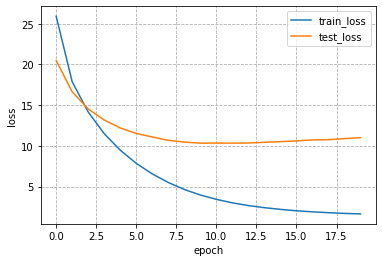

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_losses, label="train_loss")
fig_plot.plot(test_losses, label="test_loss")
fig_plot.legend(loc="upper right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("loss")
fig_plot.grid(linestyle="--")
fig.savefig("losses_plot.png")
fig.show()

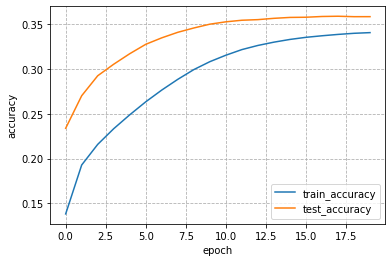

In [13]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_accuracyVec, label="train_accuracy")
fig_plot.plot(test_accuracyVec, label="test_accuracy")
fig_plot.legend(loc="lower right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("accuracy")
fig_plot.grid(linestyle="--")
fig.savefig("accuracy_plot.png")